<a href="https://colab.research.google.com/github/Armanskij/EBAC_Studies/blob/main/Profissao_Analista_de_dados_M38_Exercicio_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)
<br>
Elaborado por [Douglas Rizzi](https://www.linkedin.com/in/douglas-rizzi/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Aulas**

## 1\. AWS Lambda

O AWS [Lambda](https://aws.amazon.com/pt/lambda/) é um serviço de computação orientado a evento e sem servidor. Permite a execução de uma função em diversas linguagens de programação que utilize entre 128 MB e 10 GB de memória RAM e que dure, no máximo, 15 minutos. É conhecido com FaaS (*function as a service*) ou função como serviço.

> O nome do serviço é inspirado em funções lambda do paradigma funcional.

### **1.1. Funcionamento**

 1. Ao criar uma função, o *runtime* (linguagem de programação + versão) é escolhida;
 1. A função sempre recebe dois parametros: `event` (*input*) e `context` (execução);
 1. Código refatorado precisa ser implantado (*deploy*);
 1. Código pode ser testado;
 1. Recursos (memória e tempo de execução) podem ser configurados;
 1. Funções precisam de permissão para acessar outros serviços (*buckets*, tabelas, etc.) via AWS [IAM](https://aws.amazon.com/pt/iam/);
 1. Execution logs can be found on AWS [CloudWatch](https://aws.amazon.com/pt/cloudwatch/).

### **1.2. Preço**

O AWS [Lambda](https://aws.amazon.com/pt/lambda/) cobra por quantidade de execução, tempo de execução e memória alocada. Sobre a quantidade de execução, o preço é de 0,20 USD por milhão de execuções (1,11 BRL). Já sobre tempo de execução e memória alocada, o preço é de 0,0000166667 USD por GB por segundo (0.00009 BRL). Você sempre deve consultar o preço na página *web* do serviço ([link](https://aws.amazon.com/pt/lambda/pricing/)).

### **1.3. Atividade**

Extrair dados da site da [BCB](https://api.bcb.gov.br/) através de uma [API](https://api.bcb.gov.br/dados/serie/bcdata.sgs.4392/dados?formato=json):

In [1]:
import json
from datetime import datetime
import requests

# -- setup
URL = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.4392/dados?formato=json'

# -- extract
try:
    response = requests.get(URL)
    response.raise_for_status()
except requests.exceptions.RequestException as exc:
    raise SystemExit(exc)
else:
    data = json.loads(response.text)

# -- transform
transformed_data = []

for record in data:
    transformed_record = {
        'taxa': record['valor'].replace(',', '.'),
        'dataTaxa': datetime.strptime(record['data'], '%d/%m/%Y').strftime('%Y-%m-%d'),
    }
    transformed_data.append(transformed_record)

# Convert data to CSV format
csv_data = '\n'.join([','.join([record['taxa'], record['dataTaxa']]) for record in transformed_data])

example_record = transformed_data[0]
print(f"taxa: {example_record['taxa']}, dataTaxa: {example_record['dataTaxa']}")

with open('transformed_data.csv', 'w') as f:
    f.write('taxa,dataTaxa\n')
    f.write(csv_data)

print('CSV file saved successfully.')

taxa: 40.85, dataTaxa: 1986-08-01
CSV file saved successfully.


Vamos dividir essa etapa em duas: extração e transformação. Logo, temos que:

- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado original (`bronze`);
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para extrair o dado original;
- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado transformado  (`silver`);
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para transformar o dado original;
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para criar uma tabela no AWS [Athena](https://aws.amazon.com/pt/athena) apontando para o *bucket* do dado transformado.



Vamos também usar o pacote Python [boto3](https://pypi.org/project/boto3/), o SDK (*software development kit*) da AWS para interação com os serviços da plataforma. A documentação pode ser encontrada neste [link](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html). Exemplo:

```python
import boto3

client = boto3.client('s3')
client.upload_file(Filename='<nome-do-arquivo>', Bucket='<nome-do-bucket>', Key='<nome-do-objeto>')

client = boto3.client('athena')
client.start_query_execution(
  QueryString='SELECT * FROM <nome-da-tabela> LIMIT 10',
  ResultConfiguration={'OutputLocation': 's3://<nome-do-bucket-de-resultados>/'}
)
```

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **bronze**:

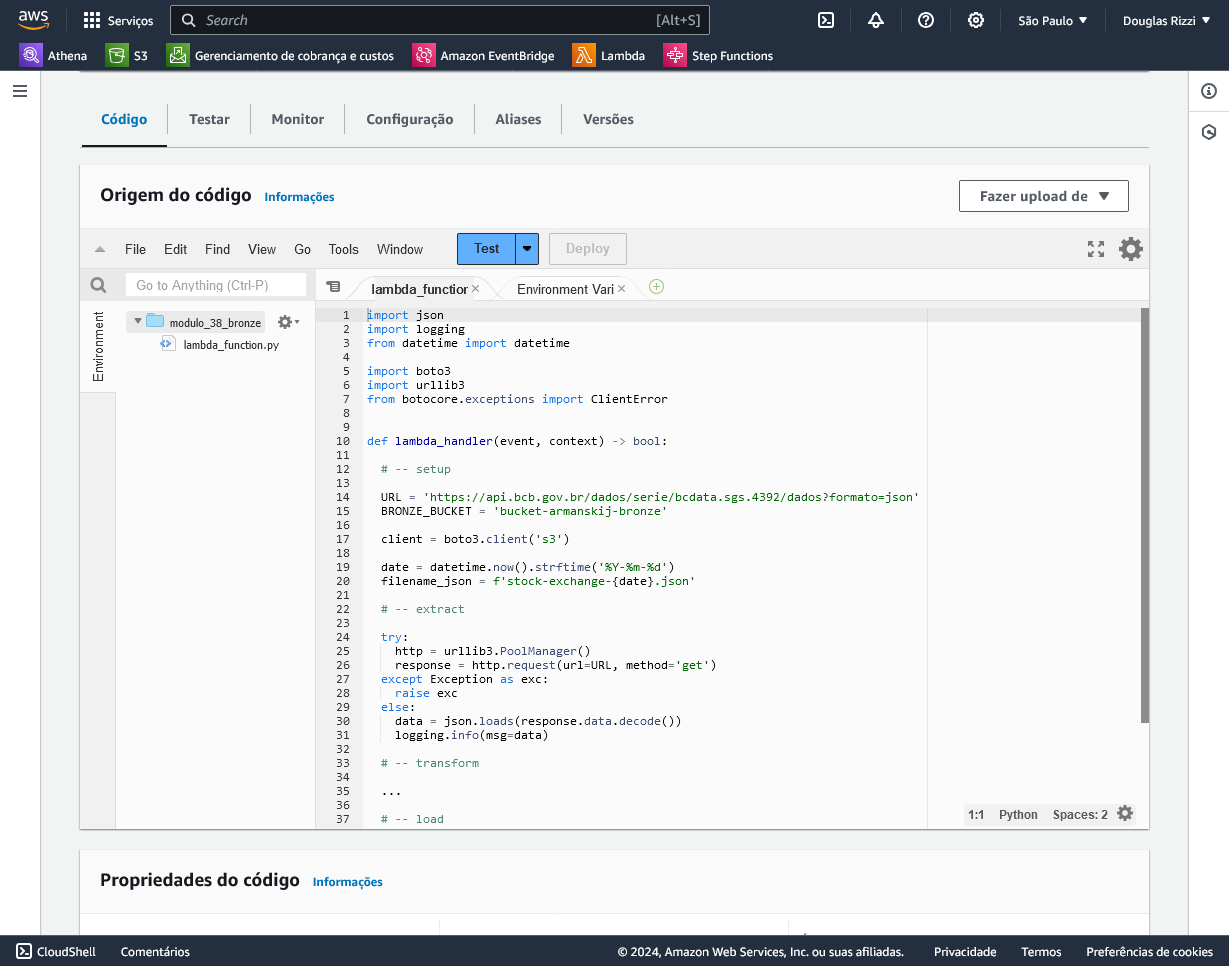

In [6]:
from IPython.display import Image
Image(filename="/content/função bronze API.png")

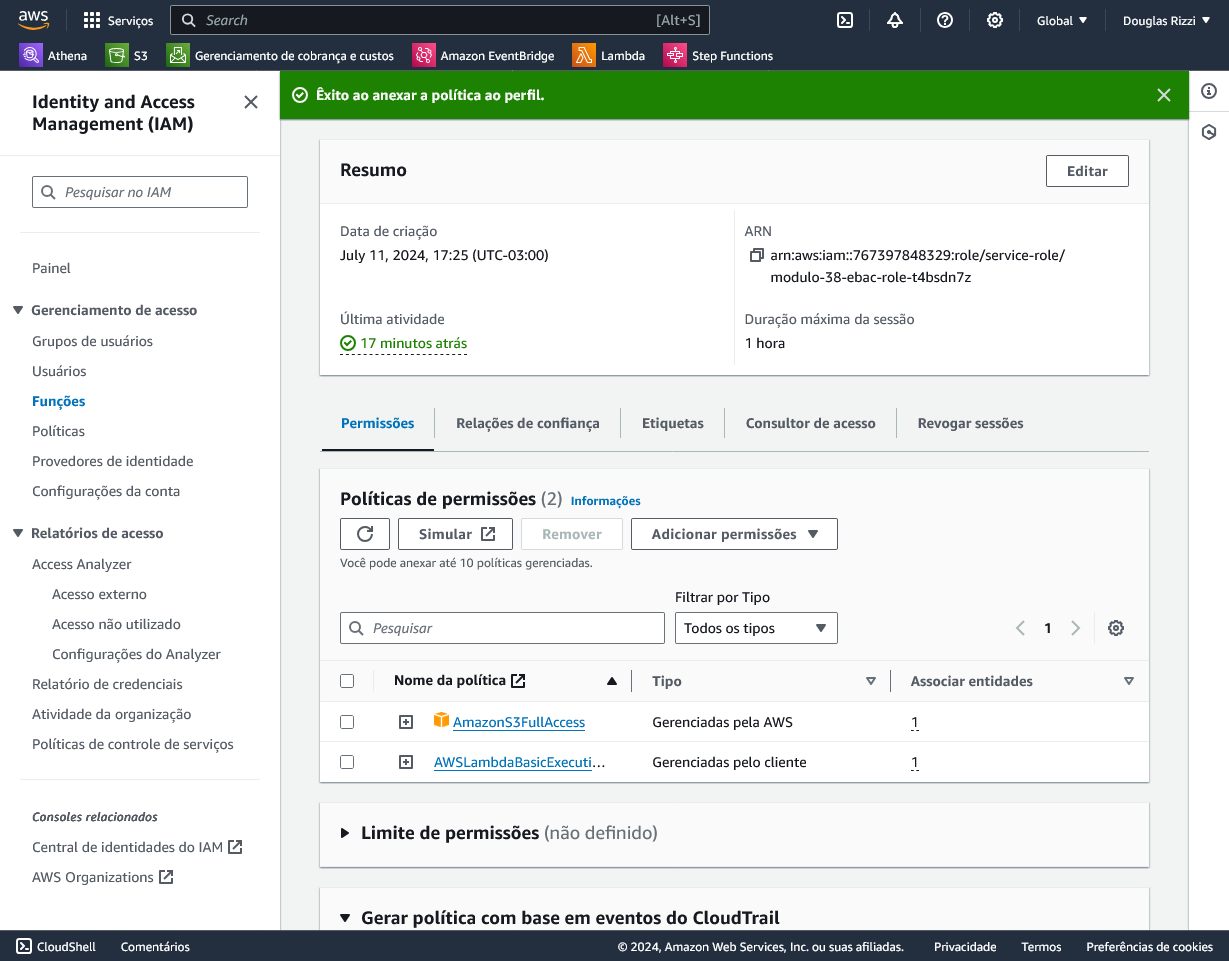

In [7]:
Image(filename="/content/anexando_politicas.png")

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **silver**:

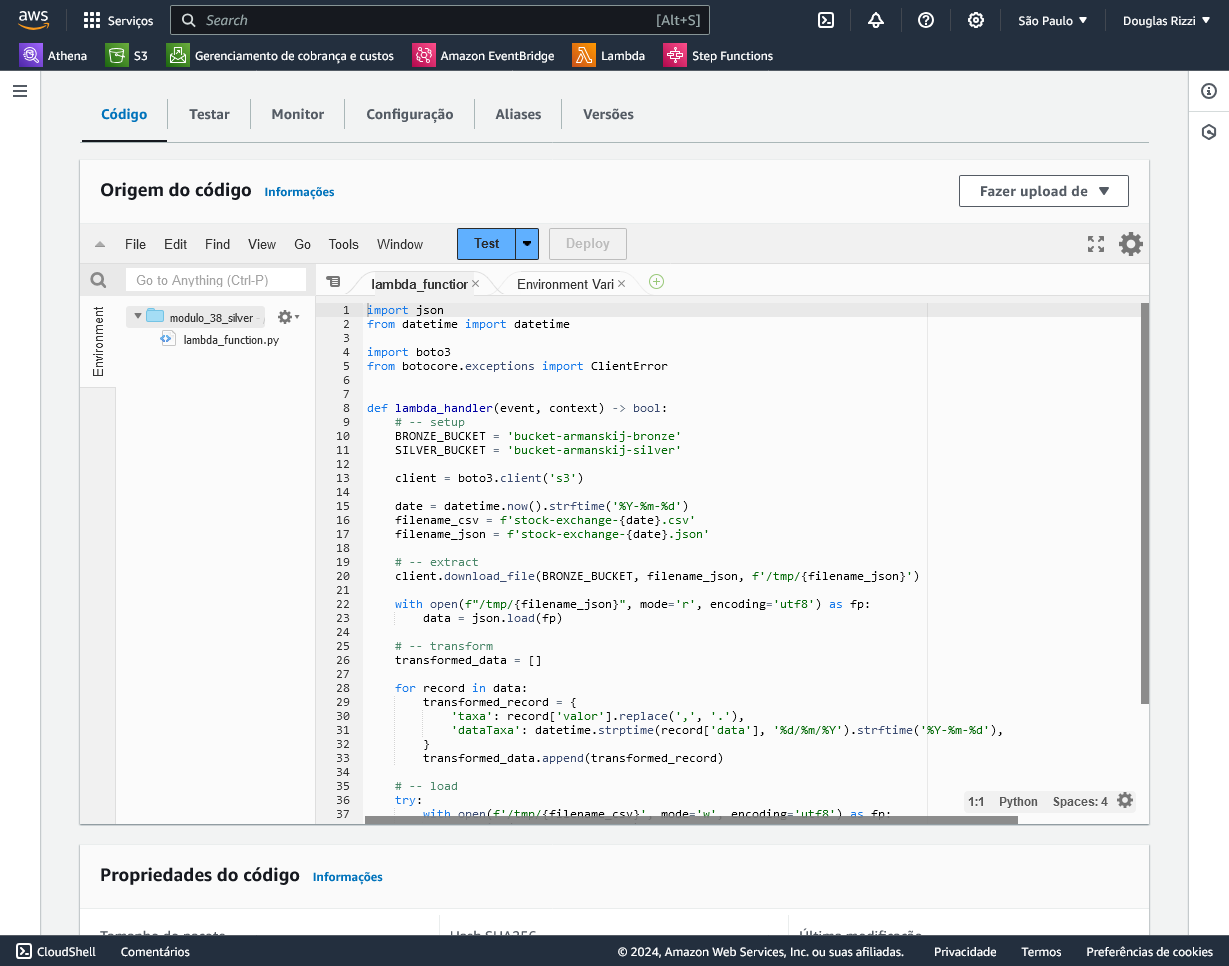

In [9]:
Image(filename="/content/função silver transformação.png")

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para tabela:

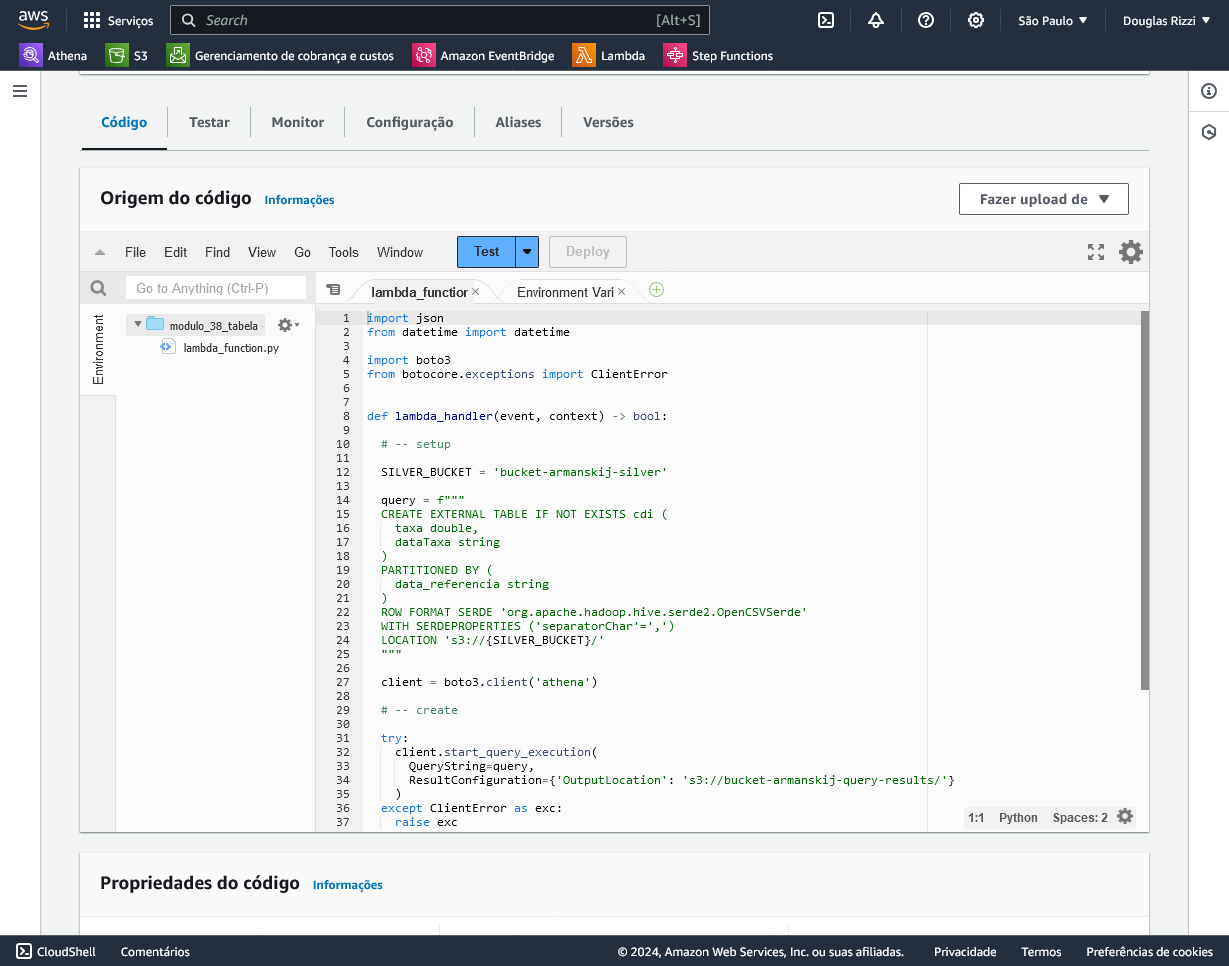

In [10]:
Image(filename="/content/função tabela.png")

Listagem das 3 funções criadas:


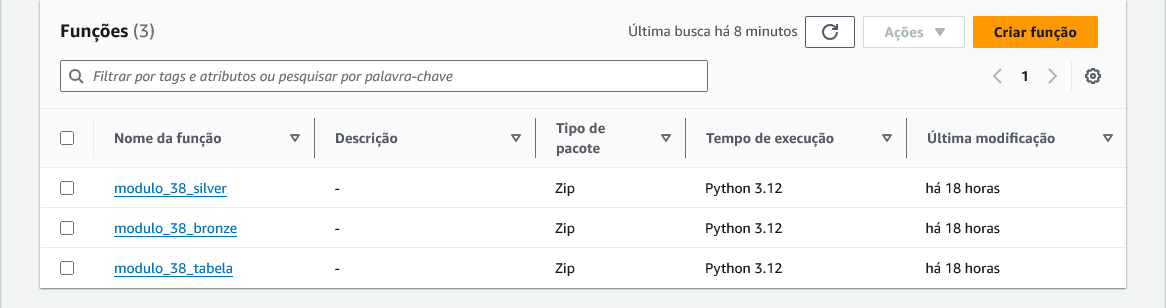

In [25]:
Image(filename="/content/lista de funções.png")

## 2\. AWS Step Functions

O AWS [Step Functions](https://aws.amazon.com/pt/step-functions/) é um serviço de orquestração de serviços sem servidor. No contexto de dados, pode atuar como orquestrador de *pipeline* de dados. O serviço é inspirado no famoso projeto *open source* [Apache Airflow](https://airflow.apache.org).



### **2.1. Funcionamento**

1. Uma *task* ou tarefa é uma unidade de processamento;
2. Uma *state machine* é a definição de um fluxo de tarefas;
3. Tasks e state machine são definidas com a linguagem JSON.

### **2.2. Preço**

O AWS [Step Functions](https://aws.amazon.com/pt/step-functions/) cobra por transição de estado. O preço é de 0,0375 USD por 1.000 transições de estado (0,21 BRL). Você sempre deve consultar o preço na página *web* do serviço ([link](https://aws.amazon.com/pt/step-functions/pricing/)).

### **2.3. Atividade**

 - Criar uma `state machine` com três *tasks*, uma com cada função lambda criada na item 1.3.

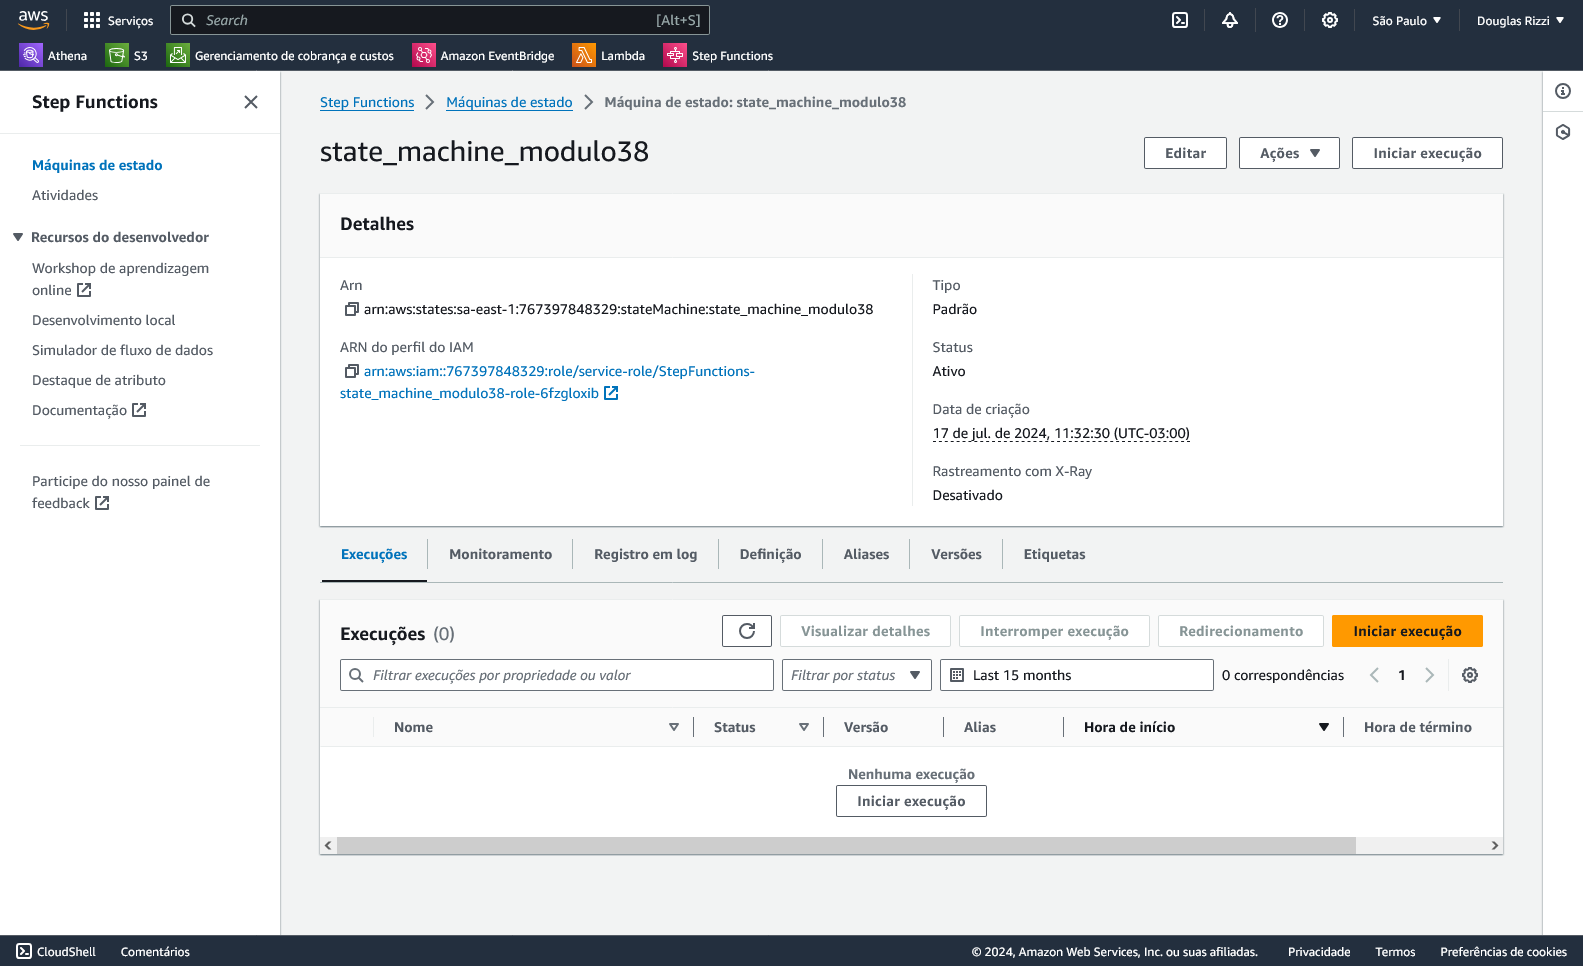

In [21]:
Image(filename="/content/step function.png")

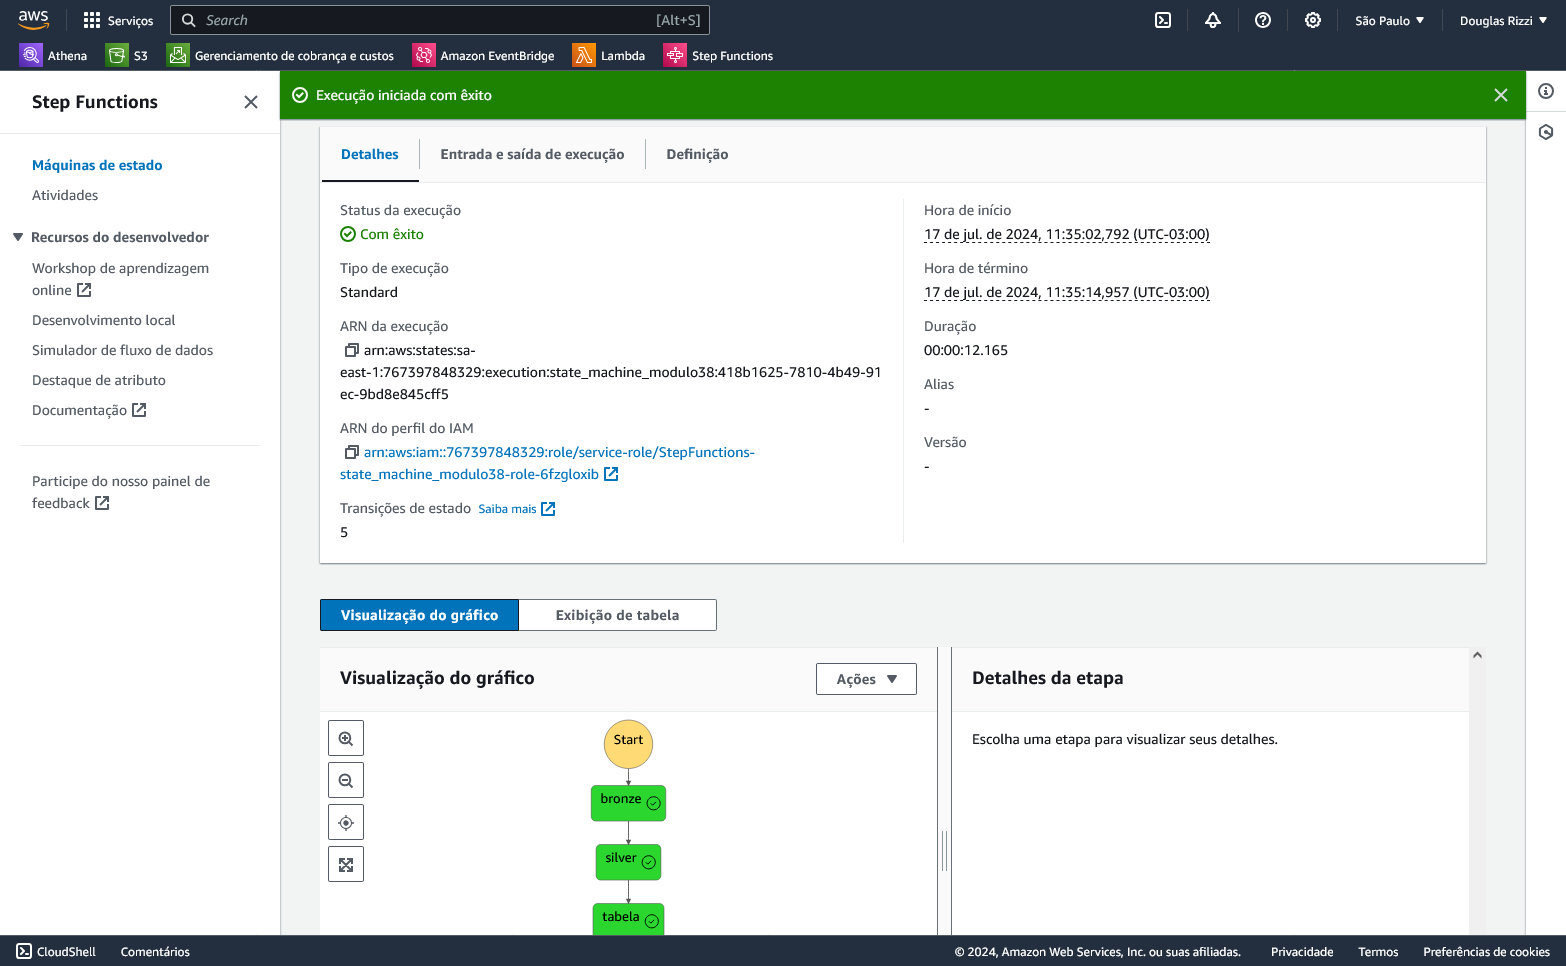

In [22]:
Image(filename="/content/state machine.png")

## 3\. AWS EventBridge

O AWS [EventBridge](https://aws.amazon.com/pt/eventbridge/) é um serviço de barramento de eventos sem servidor. Ele permite que multiplos serviços da AWS se comuniquem de maneira assíncrona através da publicação/consumo de eventos.


### **3.1. Funcionamento**

1. Uma *rule* ou regra "escuta" eventos e os roteia para serviços da AWS;
2. Eventos podem ser temporais ou publicações de outros serviços da AWS;
2. Eventos também podem se publicados serviços externos (Shopfy, Zendesk, etc.).

### **3.2. Preço**

O AWS [EventBridge](https://aws.amazon.com/pt/eventbridge/) é gratuito para publicação/consumo de eventos entre serviços da AWS. Você sempre deve consultar o preço na página web do serviço ([link](https://aws.amazon.com/pt/eventbridge/pricing/)).

### **3.3. Atividade**

 - Criar um evento que inicie a *state machine* do item 2.3.

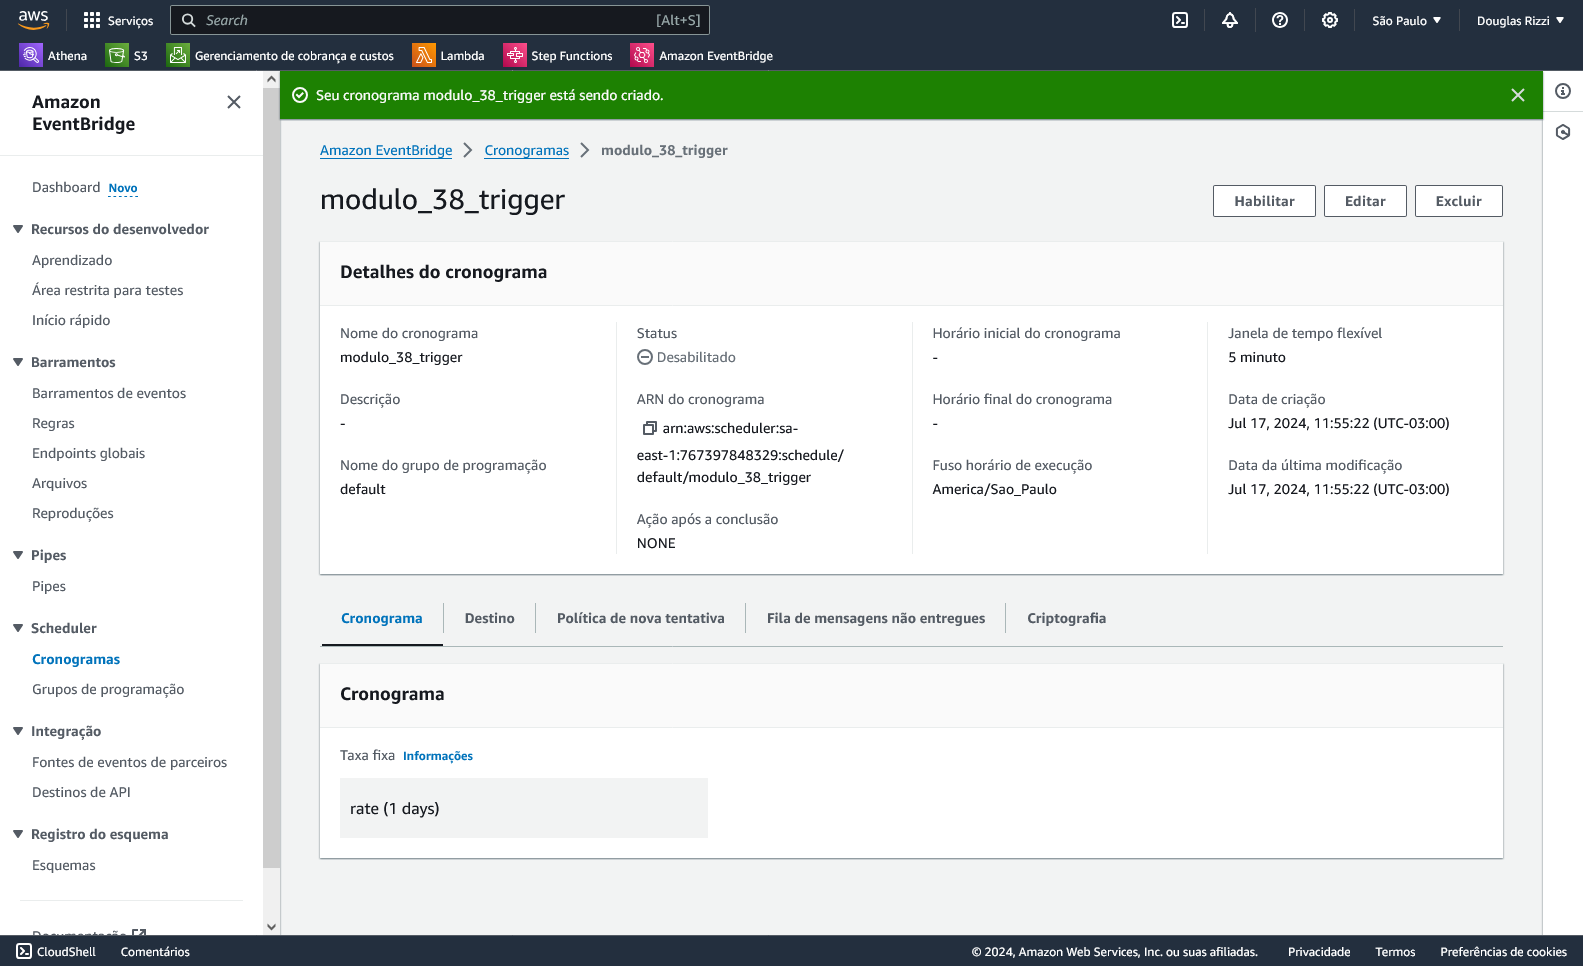

In [23]:
Image(filename="/content/event bridge.png")